# Road Signs classification using PyTorch and the GTSRB dataset

In [150]:
%%javascript
var rate = 0;
// apply setting to  all current CodeMirror instances
IPython.notebook.get_cells().map(
    function(c) {  return c.code_mirror.options.cursorBlinkRate=rate;  }
);

// make sure new CodeMirror instance also use this setting
CodeMirror.defaults.cursorBlinkRate=rate;

<IPython.core.display.Javascript object>

In [151]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid

In [152]:
class RoadSignsDataset(Dataset):
    def __init__(self, datasets_path, csv_name):
        self.metadatas = pd.read_csv(datasets_path + '/' + csv_name)
        self.datasets_path = datasets_path
        self.transform = torch.nn.Sequential(
            transforms.Resize(64),
            transforms.CenterCrop(64)#,
            #transforms.Normalize((0.485 * 255, 0.456 * 255, 0.406 * 255), (0.229 * 255, 0.224 * 255, 0.225 * 255))
        )
    
    def __len__(self):
        return len(self.metadatas.index)
    
    def __getitem__(self, idx):
        img_path = self.metadatas.loc[idx, "Path"]
        image = read_image(self.datasets_path + '/' + img_path).float()
        image = self.transform(image)
        label = self.metadatas.loc[idx, "ClassId"]
        return image, label

In [153]:
from torch.utils.data import DataLoader
from torchvision import transforms

test_data = RoadSignsDataset("datasets", "Test.csv")
train_data = RoadSignsDataset("datasets", "Train.csv")

test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)

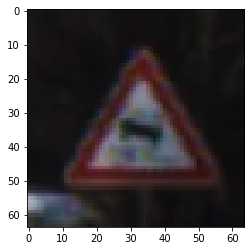

In [162]:
import matplotlib.pyplot as plt

batch_features, batch_labels = next(iter(train_dataloader))
img = batch_features[0].squeeze()
label = batch_labels[0]
#print(img)
#plt.imshow(img.int().permute(1, 2, 0))
#plt.show()

def imshow(floatTensor):
    plt.imshow(floatTensor.int().permute(1, 2, 0))
    plt.show()
    
imshow(img)

In [168]:
from torchsummary import summary

class convGTSRB(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 5, 5, 1)
        self.conv2 = nn.Conv2d(5, 20, 3, 1)
        
        self.fc1 = nn.Linear(14 * 14 * 20, 120)
        self.fc2 = nn.Linear(120, 80)
        self.fc3 = nn.Linear(80, 43)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = x.view(-1, 14 * 14 * 20)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim = 1)
        return x
    
model = convGTSRB()
summary(model, (3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 5, 60, 60]           380
├─Conv2d: 1-2                            [-1, 20, 28, 28]          920
├─Linear: 1-3                            [-1, 120]                 470,520
├─Linear: 1-4                            [-1, 80]                  9,680
├─Linear: 1-5                            [-1, 43]                  3,483
Total params: 484,983
Trainable params: 484,983
Non-trainable params: 0
Total mult-adds (M): 2.54
Input size (MB): 0.05
Forward/backward pass size (MB): 0.26
Params size (MB): 1.85
Estimated Total Size (MB): 2.16


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 5, 60, 60]           380
├─Conv2d: 1-2                            [-1, 20, 28, 28]          920
├─Linear: 1-3                            [-1, 120]                 470,520
├─Linear: 1-4                            [-1, 80]                  9,680
├─Linear: 1-5                            [-1, 43]                  3,483
Total params: 484,983
Trainable params: 484,983
Non-trainable params: 0
Total mult-adds (M): 2.54
Input size (MB): 0.05
Forward/backward pass size (MB): 0.26
Params size (MB): 1.85
Estimated Total Size (MB): 2.16

In [156]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
epochs = 2 # number of epochs

In [157]:
sum_loss = 0
n = 0

for epoch in range(epochs):
    for b, data in enumerate(train_dataloader):
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        #print(outputs.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        sum_loss += loss.item()
        n += 1
        if b % 10 == 9:
            print(f"epoch n°{epoch + 1}, batch n°{b + 1} loss is {sum_loss / n}")
            n = 0
            sum_loss = 0

epoch n°1, batch n°10 loss is 4.050504159927368
epoch n°1, batch n°20 loss is 3.6663852453231813
epoch n°1, batch n°30 loss is 3.511002278327942
epoch n°1, batch n°40 loss is 3.451927971839905
epoch n°1, batch n°50 loss is 3.4092453718185425
epoch n°1, batch n°60 loss is 3.2607296466827393
epoch n°1, batch n°70 loss is 3.242733526229858
epoch n°1, batch n°80 loss is 3.1472708940505982
epoch n°1, batch n°90 loss is 3.0743287801742554
epoch n°1, batch n°100 loss is 3.0633458375930784
epoch n°1, batch n°110 loss is 2.985724997520447
epoch n°1, batch n°120 loss is 2.9508342027664183
epoch n°1, batch n°130 loss is 2.807227897644043
epoch n°1, batch n°140 loss is 2.622166109085083
epoch n°1, batch n°150 loss is 2.7060540199279783
epoch n°1, batch n°160 loss is 2.5670732736587523
epoch n°1, batch n°170 loss is 2.476511001586914
epoch n°1, batch n°180 loss is 2.4828233242034914
epoch n°1, batch n°190 loss is 2.356500244140625
epoch n°1, batch n°200 loss is 2.405860495567322
epoch n°1, batch n°

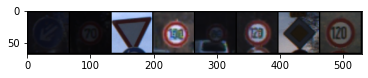

Actual:
[tensor(39), tensor(4), tensor(13), tensor(7), tensor(5), tensor(8), tensor(12), tensor(8)]
Predicted:
[tensor(39), tensor(4), tensor(13), tensor(7), tensor(23), tensor(8), tensor(12), tensor(8)]


In [158]:
images, labels = next(iter(test_dataloader))

n = 8

plt.imshow(make_grid(images[:n]).int().permute(1, 2, 0))
plt.show()

print("Actual:")
print([labels[i] for i in range(n)])

outputs = model(images)

_, predicted = torch.max(outputs, 1)

print("Predicted:")
print([predicted[i] for i in range(n)])

In [159]:
n = 0
correct = 0
b = 0

for test_batch in test_dataloader:
    b += 1
    batch_correct = 0
    images, labels = test_batch
    
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)
    n += labels.size(0)
    batch_n = labels.size(0)
    for i in range(labels.size(0)):
        if predictions[i] == labels[i]:
            correct += 1
            batch_correct += 1
            
    if b % 25 == 0:
        print(f"batch n°{b} has {batch_correct} correct out of {batch_n}")
            
print(f"accuracy of the model is : {correct / n}")

batch n°25 has 56 correct out of 64
batch n°50 has 54 correct out of 64
batch n°75 has 52 correct out of 64
batch n°100 has 55 correct out of 64
batch n°125 has 49 correct out of 64
batch n°150 has 54 correct out of 64
batch n°175 has 52 correct out of 64
accuracy of the model is : 0.8340459224069675


In [160]:
path = "models/834acc"
torch.save(model.state_dict(), path)